In [ ]:
# install packages
!pip install nilearn pandas matplotlib seaborn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
file_path = "your_file_path"

In [3]:
import pandas as pd
import numpy as np
from nilearn import image, input_data, datasets
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Data analysis

In [ ]:
data_path = 'your_file_path/filtered_data.xlsx'
data = pd.read_excel(data_path)

In [ ]:
data.describe().round(2)

PreschoolID  Age (Years)  Biological Sex (Female = 0; Male = 1)  \
count        88.00        88.00                                  88.00   
mean      10079.48         5.80                                   0.53   
std          51.73         0.57                                   0.50   
min       10006.00         5.03                                   0.00   
25%       10032.00         5.33                                   0.00   
50%       10066.00         5.73                                   1.00   
75%       10121.00         6.28                                   1.00   
max       10176.00         6.97                                   1.00   

       Maternal Postsecondary Years of Education  \
count                                      84.00   
mean                                        6.08   
std                                         2.50   
min                                         1.00   
25%                                         4.00   
50%                                         6.00   
75%                                         7.25   
max                                        14.00   

       Phonological Processing Standard Score  Speeded Naming Standard Score  \
count                                   88.00                          88.00   
mean                                    11.77                          11.80   
std                                      2.70                           2.69   
min                                      3.00                           4.00   
25%                                     10.00                          10.00   
50%                                     12.00                          12.00   
75%                                     14.00                          13.00   
max                                     19.00                          17.00   

       Phonological Processing Raw Score  Speeded Naming Completion Time  \
count                              88.00                           88.00   
mean                               24.58                          134.56   
std                                 5.67                           56.97   
min                                 8.00                           20.00   
25%                                21.00                           96.75   
50%                                24.00                          123.00   
75%                                28.00                          161.25   
max                                39.00                          330.00   

       Speeded Naming Number Correct  
count                          88.00  
mean                           77.97  
std                            12.46  
min                            24.00  
25%                            79.75  
50%                            82.00  
75%                            83.00  
max                            84.00


Independent Samples t-test for Speeded Naming Standard Score:
t-statistic: -1.1006
p-value: 0.2741
Conclusion: There is no statistically significant difference in the mean Speeded Naming Standard Score between the 5-6 and 6-7 age groups (p >= 0.05).


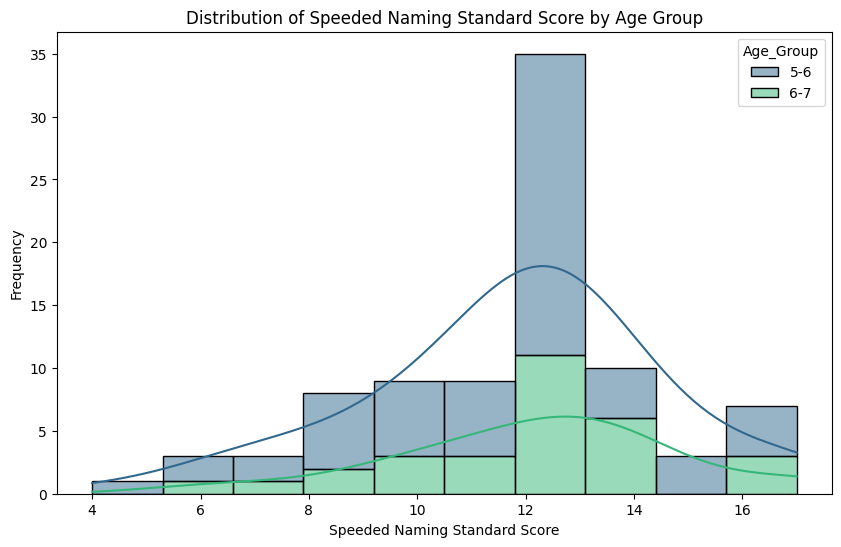

In [ ]:
group1_naming_scores = data[data['Age_Group'] == '5-6']['Speeded Naming Standard Score'].dropna()
group2_naming_scores = data[data['Age_Group'] == '6-7']['Speeded Naming Standard Score'].dropna()

# Check if both groups have enough data points for a t-test
if len(group1_naming_scores) > 1 and len(group2_naming_scores) > 1:
    # Perform an independent samples t-test
    t_stat_naming, p_value_naming = ttest_ind(group1_naming_scores, group2_naming_scores)

    print(f"\nIndependent Samples t-test for Speeded Naming Standard Score:")
    print(f"t-statistic: {t_stat_naming:.4f}")
    print(f"p-value: {p_value_naming:.4f}")

    alpha = 0.05
    if p_value_naming < alpha:
        print("Conclusion: The mean Speeded Naming Standard Score is significantly different between the 5-6 and 6-7 age groups (p < 0.05).")
    else:
        print("Conclusion: There is no statistically significant difference in the mean Speeded Naming Standard Score between the 5-6 and 6-7 age groups (p >= 0.05).")
else:
    print("\nNot enough data points in one or both age groups to perform a t-test for Speeded Naming Standard Score.")
    print(f"Count for 5-6 group: {len(group1_naming_scores)}")
    print(f"Count for 6-7 group: {len(group2_naming_scores)}")

# Visualize the distribution of Speeded Naming Standard Score by Age Group
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Speeded Naming Standard Score', hue='Age_Group', multiple="stack", palette="viridis", kde=True)
plt.title('Distribution of Speeded Naming Standard Score by Age Group')
plt.xlabel('Speeded Naming Standard Score')
plt.ylabel('Frequency')
plt.show()

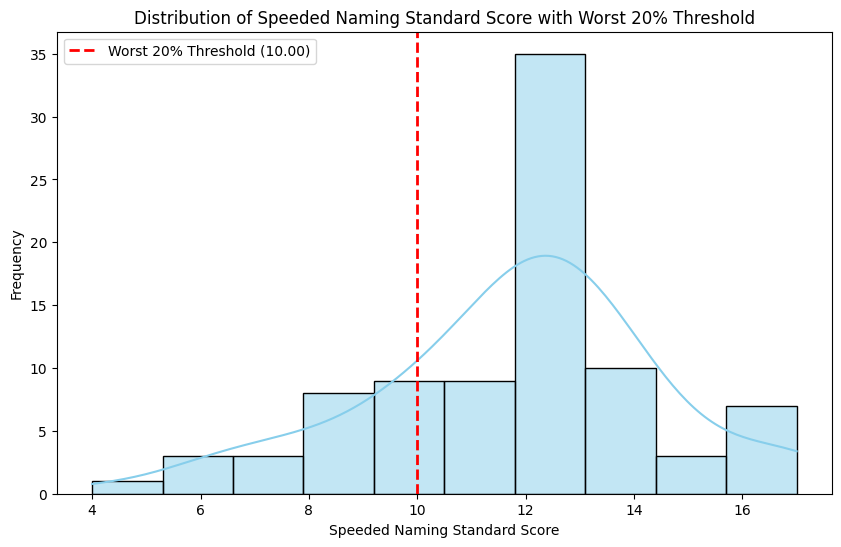


Threshold for the worst 20% of Speeded Naming Standard Score: 10.00


In [ ]:
threshold = data['Speeded Naming Standard Score'].quantile(0.20) # 20% threshold

plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Speeded Naming Standard Score', kde=True, color='skyblue') # Use a single color for the overall distribution
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f'Worst 20% Threshold ({threshold:.2f})')
plt.title('Distribution of Speeded Naming Standard Score with Worst 20% Threshold')
plt.xlabel('Speeded Naming Standard Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(f"\nThreshold for the worst 20% of Speeded Naming Standard Score: {threshold:.2f}")


# Neuroimaging data analysis 🧠

In [ ]:
import os
import numpy as np
from nilearn import image, datasets
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
import glob
import pandas as pd
import seaborn as sns

In [ ]:
data.head(3)

PreschoolID    ScanID RSFC?  Age (Years)  \
0        10059  PS17_026   Yes       6.9000   
1        10065  PS16_043   Yes       5.7444   
2        10022  PS17_030   Yes       6.9694   

   Biological Sex (Female = 0; Male = 1) Handedness  \
0                                      1      Right   
1                                      0      Right   
2                                      1      Right   

   Maternal Postsecondary Years of Education  \
0                                        6.0   
1                                        4.0   
2                                        4.0   

   Phonological Processing Standard Score  Speeded Naming Standard Score  \
0                                      14                             14   
1                                      11                             16   
2                                      11                             13   

   Phonological Processing Raw Score  Speeded Naming Completion Time  \
0                                 34                              82   
1                                 23                              90   
2                                 27                              92   

   Speeded Naming Number Correct  \
0                             83   
1                             84   
2                             83   

                                       Z_matrix_path  
0  /content/drive/MyDrive/BHS 25 Project/RSFC_out...  
1  /content/drive/MyDrive/BHS 25 Project/RSFC_out...  
2  /content/drive/MyDrive/BHS 25 Project/RSFC_out...

In [ ]:
# Fetch Destrieux (2009) atlas
print("Fetching Destrieux atlas...")
atlas = datasets.fetch_atlas_destrieux_2009(lateralized=True)
atlas_path = atlas['maps']
print(f"Using atlas file: {atlas_path}")

Fetching Destrieux atlas...


[_add_readme_to_default_data_locations] Added README.md to /root/nilearn_data

[get_dataset_dir] Dataset created in /root/nilearn_data/destrieux_2009

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/11942/destrieux2009.tgz ...

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/destrieux_2009/2a2e5a5707983d509d9319c692c867ab/destrieux2009.tgz...

[uncompress_file] .. done.

Using atlas file: /root/nilearn_data/destrieux_2009/destrieux2009_rois_lateralized.nii.gz


In [ ]:
labels = atlas['labels']

In [ ]:
labels

name
index                         
0                   Background
1       L G_and_S_frontomargin
2      L G_and_S_occipital_inf
3        L G_and_S_paracentral
4         L G_and_S_subcentral
...                        ...
146             R S_suborbital
147            R S_subparietal
148           R S_temporal_inf
149           R S_temporal_sup
150    R S_temporal_transverse

[151 rows x 1 columns]

In [ ]:
masker = NiftiLabelsMasker(labels_img=atlas_path, standardize=True, detrend=True, t_r=2.0)
correlation_measure = ConnectivityMeasure(kind='correlation')

In [ ]:
save_dir = 'your_file_path/BHS 25 Project/RSFC_output'
os.makedirs(save_dir, exist_ok=True)

### Processing batch data using for loop

In [ ]:
# 設定 RSFC output 資料夾
rsfc_dir = 'your_file_path'

# 抓出所有 .npy Z-matrix 檔案
z_files = glob.glob(os.path.join(rsfc_dir, '*_RSFC_Z_matrix.npy'))
z_files.sort()

# 儲存 metadata
subject_ids = []
scan_ids = []
z_matrices = []

# 讀入所有固定 shape 的 Z-matrix
for f in z_files:
    basename = os.path.basename(f)
    parts = basename.split('_RSFC_Z_matrix.npy')[0].split('_')
    subject_id = parts[0]
    scan_id = '_'.join(parts[1:])  # 考慮 scan_id 裡有底線

    z_mat = np.load(f)

    # 驗證是否為一致 shape（148x148）
    if z_mat.shape != (148, 148):
        print(f'⚠️ Skipping {basename}, unexpected shape {z_mat.shape}')
        continue

    subject_ids.append(subject_id)
    scan_ids.append(scan_id)
    z_matrices.append(z_mat)

    print(f'✅ Loaded {subject_id} {scan_id}, shape: {z_mat.shape}')

# 整合成 big array
z_matrices_array = np.stack(z_matrices)  # shape: [n_scans, 148, 148]

# 儲存
np.save(os.path.join(rsfc_dir, 'big_RSFC_Z_array.npy'), z_matrices_array)

index_df = pd.DataFrame({
    'PreschoolID': subject_ids,
    'ScanID': scan_ids,
    'Z_matrix_path': z_files[:len(subject_ids)]
})
index_df.to_csv(os.path.join(rsfc_dir, 'RSFC_index_table.csv'), index=False)

print(f'\n🎉 Done: {len(subject_ids)} scans loaded.')
print(f'Z-matrix array shape: {z_matrices_array.shape}')
print(f'Saved to:\n- big_RSFC_Z_array.npy\n- RSFC_index_table.csv')

✅ Loaded 10008 PS14_046, shape: (148, 148)
⚠️ Skipping 10008_PS14_079_RSFC_Z_matrix.npy, unexpected shape (146, 146)
⚠️ Skipping 10008_PS16_001_RSFC_Z_matrix.npy, unexpected shape (136, 136)
✅ Loaded 10008 PS16_045, shape: (148, 148)
⚠️ Skipping 10008_PS17_018_RSFC_Z_matrix.npy, unexpected shape (139, 139)
⚠️ Skipping 10009_PS14_070_RSFC_Z_matrix.npy, unexpected shape (96, 96)
✅ Loaded 10009 PS15_002, shape: (148, 148)
⚠️ Skipping 10009_PS15_092_RSFC_Z_matrix.npy, unexpected shape (112, 112)
⚠️ Skipping 10009_PS16_020_RSFC_Z_matrix.npy, unexpected shape (71, 71)
✅ Loaded 10009 PS16_072, shape: (148, 148)
⚠️ Skipping 10009_PS17_029_RSFC_Z_matrix.npy, unexpected shape (144, 144)
⚠️ Skipping 10010_PS14_005_RSFC_Z_matrix.npy, unexpected shape (125, 125)
✅ Loaded 10010 PS15_014, shape: (148, 148)
⚠️ Skipping 10010_PS15_095_RSFC_Z_matrix.npy, unexpected shape (147, 147)
⚠️ Skipping 10010_PS16_004_RSFC_Z_matrix.npy, unexpected shape (146, 146)
✅ Loaded 10010 PS16_046, shape: (148, 148)
⚠️ Ski

# whole-brain (group-level) heatmap

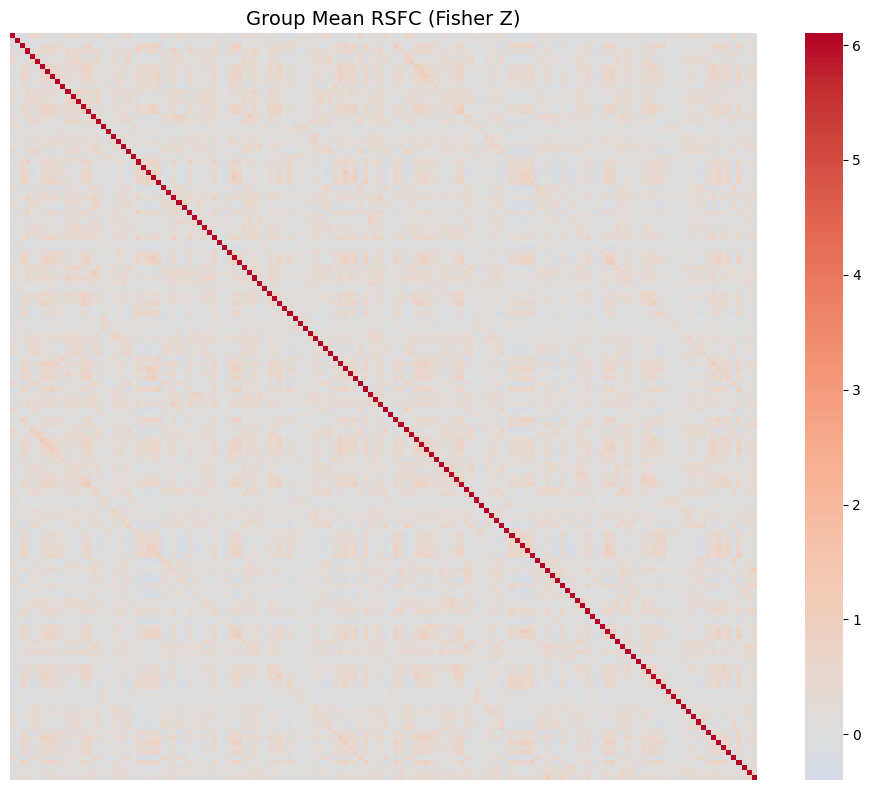

In [ ]:
z_array_path = 'your_file_path/BHS 25 Project/RSFC_output/big_RSFC_Z_array.npy'
z_array = np.load(z_array_path)  # shape: (34, 148, 148)

mean_z = np.mean(z_array, axis=0)  # shape: (148, 148)

plt.figure(figsize=(10, 8))
sns.heatmap(mean_z, cmap='coolwarm', center=0, square=True, xticklabels=False, yticklabels=False)
plt.title('Group Mean RSFC (Fisher Z)', fontsize=14)
plt.tight_layout()

# save image to your_file_path
plt.savefig('your_file_path/BHS 25 Project/RSFC_output/group_mean_RSFC_heatmap.png', dpi=300)
plt.show()

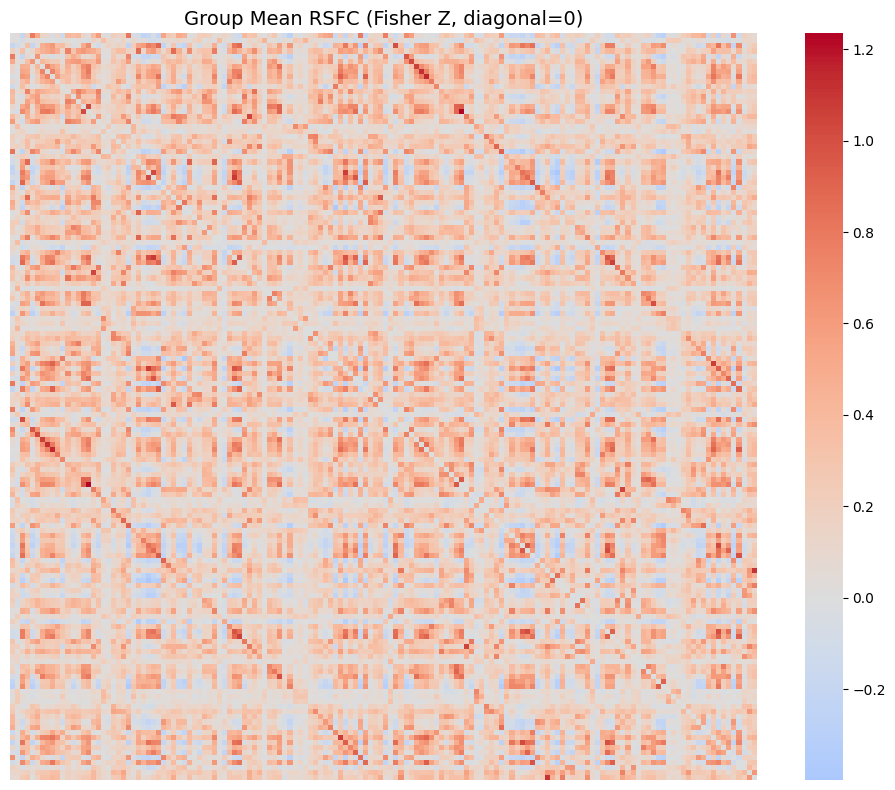

In [ ]:
# update Z upper/lower score for plotting
mean_z_no_diag = mean_z.copy()
np.fill_diagonal(mean_z_no_diag, 0)

plt.figure(figsize=(10, 8))
sns.heatmap(mean_z_no_diag, cmap='coolwarm', center=0, square=True, xticklabels=False, yticklabels=False)
plt.title('Group Mean RSFC (Fisher Z, diagonal=0)', fontsize=14)
plt.tight_layout()
plt.savefig('your_file_path/BHS 25 Project/RSFC_output/group_mean_RSFC_heatmap_no_diag.png', dpi=300)
plt.show()

### import Destrieux (2009) atlas

In [4]:
from nilearn.datasets import fetch_atlas_destrieux_2009
from nilearn import plotting

atlas = fetch_atlas_destrieux_2009(lateralized=True)
atlas_img = atlas['maps']

coords = plotting.find_parcellation_cut_coords(labels_img=atlas_img)

print(f"Loaded {len(coords)} ROI coordinates.")

[_add_readme_to_default_data_locations] Added README.md to /root/nilearn_data

[get_dataset_dir] Dataset created in /root/nilearn_data/destrieux_2009

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/11942/destrieux2009.tgz ...

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/destrieux_2009/2a2e5a5707983d509d9319c692c867ab/destrieux2009.tgz...

[uncompress_file] .. done.

Loaded 148 ROI coordinates.


In [ ]:
from nilearn.plotting import view_connectome
from IPython.display import HTML, display

view = view_connectome(mean_z, coords, edge_threshold="99%", node_size=5)

view.save_as_html('/content/drive/MyDrive/BHS 25 Project/RSFC_output/group_connectome_3D.html')
print("Saved as HTML.")

try:
    display(HTML(view._repr_html_()))
except Exception as e:
    print(f'Inline display failed: {e}')

✅ Saved as HTML.


/usr/local/lib/python3.11/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


<Figure size 800x600 with 0 Axes>

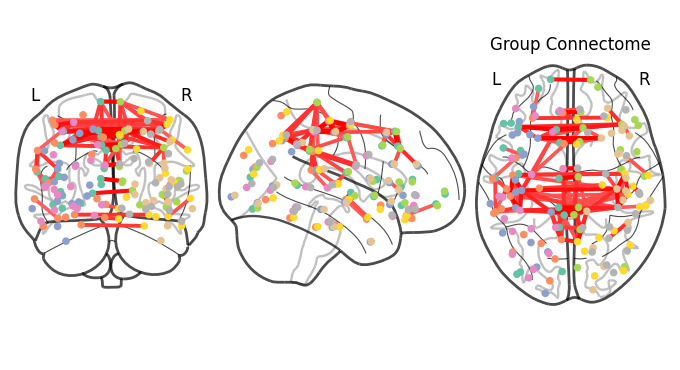

In [ ]:
from nilearn.plotting import plot_connectome

plt.figure(figsize=(8, 6))
plot_connectome(mean_z, coords, edge_threshold="99%", node_size=20, edge_vmax=1, edge_vmin=0)
plt.title('Group Connectome')
plt.savefig('/content/drive/MyDrive/BHS 25 Project/RSFC_output/group_connectome_plotconnectome_vmax06.png', dpi=300)
plt.show()

# Network-based plot

In [ ]:
# create network dictionary
network_keywords = {
    'Default Mode': [
        'G_cingul-Post-ventral',  # Posterior cingulate
        'G_cingul-Post-dorsal',   # Posterior cingulate dorsal
        'G_cingul-Front',         # Medial prefrontal cortex
        'G_precuneus',            # Precuneus
        'G_pariet_inf-Angular'    # Angular gyrus
    ],
    'Language': [
        'G_temp_sup-Lateral',     # Superior temporal gyrus
        'G_temp_sup-Plan_tempo',  # Planum temporale
        'G_temp_mid',             # Middle temporal gyrus
        'G_temp_inf',             # Inferior temporal gyrus
        'G_front_inf-Triangul',   # IFG triangular part
        'G_front_inf-Opercul',    # IFG opercular part
        'G_front_inf-Orbital'     # IFG orbital part
    ],
    'Visual': [
        'G_occipital_middle',     # Middle occipital gyrus
        'G_occipital_sup',        # Superior occipital gyrus
        'G_occipital_inf',        # Inferior occipital gyrus
        'G_occipital_lateral',    # Lateral occipital gyrus
        'G_cuneus',               # Cuneus
        'G_occipital_pole',       # Occipital pole
        'S_calcarine',            # Calcarine sulcus
        'G_lingual'               # Lingual gyrus
    ],
    "Visual_to_Phonological": [
        'L G_occipital_middle',
        'L G_occipital_inf',
        'L G_fusiform',
        'L G_front_inf-Triangul',
        'L G_front_inf-Opercul',
        'R G_occipital_middle',
        'R G_occipital_inf',
        'R G_fusiform',
        'R G_front_inf-Triangul',
        'R G_front_inf-Opercul'
    ],
    "Visual_Attention_Scanning": [
        'L S_intrapariet_and_P_trans',  # IPS
        'L G_pariet_sup',
        'L S_calcarine',
        'L G_occipital_middle',
        'L G_occipital_sup',
        'L G_cuneus',
        'L G_lingual',
        'R S_intrapariet_and_P_trans',
        'R G_pariet_sup',
        'R S_calcarine',
        'R G_occipital_middle',
        'R G_occipital_sup',
        'R G_cuneus',
        'R G_lingual'
    ],
    "Speech_Coordination": [
        # Cerebellum -> not in Destrieux atlas, skip
        'L G_precentral',
        'R G_precentral'
    ]
}

In [ ]:
from nilearn.datasets import fetch_atlas_destrieux_2009
from nilearn import plotting
from nilearn.plotting import view_connectome
from nilearn._utils import niimg_conversions
import pandas as pd
import numpy as np
from IPython.display import HTML, display

# === Step 1: Load Z-matrix ===
z_array = np.load('your_file_path')
mean_z = np.mean(z_array, axis=0)
np.fill_diagonal(mean_z, 0)

# === Step 2: Load atlas & compute coords ===
atlas = fetch_atlas_destrieux_2009(lateralized=True)
atlas_img = niimg_conversions.check_niimg(atlas['maps'])
atlas_data = atlas_img.get_fdata()

# === Step 3: Get unique_labels (>0) ===
unique_labels = np.unique(atlas_data)
unique_labels = unique_labels[unique_labels > 0]

# === Step 4: Load Destrieux surface CSV ===
label_csv = 'your_file_path'
label_df = pd.read_csv(label_csv)

# === Step 5: Map unique_labels → label_df ===
roi_labels_df = label_df[label_df['index'].isin(unique_labels)]
roi_labels_df = roi_labels_df.sort_values(by='index')
valid_label_names = roi_labels_df['name'].tolist()

# === Step 6: Get coords ===
coords = plotting.find_parcellation_cut_coords(labels_img=atlas_img)

# === Step 8: Define get_network_roi_idx function ===
def get_network_roi_idx(network_name, valid_label_names, network_keywords):
    keywords = network_keywords[network_name]
    roi_idx = [
        i for i, name in enumerate(valid_label_names)
        if any(keyword.lower() in name.lower() for keyword in keywords)
    ]
    return roi_idx

# === Step 9: Choose network & get ROI index ===
target_network = 'Language'
behavior_score_col = 'Speeded Naming Standard Score'

# 'Phonological Processing Raw Score'
# 'Phonological Processing Standard Score'
# 'Speeded Naming Standard Score'
# 'Speeded Naming Completion Time'

network_roi_idx = get_network_roi_idx(target_network, valid_label_names, network_keywords)

print(f'{target_network} network ROI index: {network_roi_idx}')
print([valid_label_names[i] for i in network_roi_idx])

# === Step 10: Subset Z-matrix + coords ===
mean_z_sub = mean_z[np.ix_(network_roi_idx, network_roi_idx)]
coords_sub = np.array(coords)[network_roi_idx]

# === Step 11: Plot connectome ===
view = view_connectome(
    mean_z_sub,
    coords_sub,
    edge_threshold="90%",
    node_size=10
)

# Optional: Inline display
try:
    display(HTML(view._repr_html_()))
except Exception as e:
    print(f'⚠️ Inline display failed: {e}')

[get_dataset_dir] Dataset found in /root/nilearn_data/destrieux_2009

Visual network ROI index: [10, 18, 19, 43, 84, 92, 93, 117]
['L G_cuneus', 'L G_occipital_middle', 'L G_occipital_sup', 'L S_calcarine', 'R G_cuneus', 'R G_occipital_middle', 'R G_occipital_sup', 'R S_calcarine']
✅ Saved Visual Network Connectome 3D HTML.


/usr/local/lib/python3.11/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Correlation between network strength and behavioral scores

In [ ]:
# set up target_network & behavior_score_col
target_network = 'Default Mode'

#'Default Mode', 'Language', 'Visual', 'Visual_to_Phonological', 'Phonological_Processing', 'Visual_Attention_Scanning', 'Speech_Coordination'

behavior_score_col = 'Speeded Naming Standard Score'

# 'Phonological Processing Raw Score'
# 'Phonological Processing Standard Score'
# 'Speeded Naming Standard Score'
# 'Speeded Naming Completion Time'

In [ ]:
def get_network_roi_idx(network_name, valid_label_names, network_keywords):
    keywords = network_keywords[network_name]
    roi_idx = [
        i for i, name in enumerate(valid_label_names)
        if any(keyword.lower() in name.lower() for keyword in keywords)
    ]
    return roi_idx

network_roi_idx = get_network_roi_idx(target_network, valid_label_names, network_keywords)
print(f'{target_network} network ROI index: {network_roi_idx}')
print([valid_label_names[i] for i in network_roi_idx])

[get_dataset_dir] Dataset found in /root/nilearn_data/destrieux_2009

Default Mode network ROI index: [8, 9, 24, 29, 82, 83, 98, 103]
['L G_cingul-Post-dorsal', 'L G_cingul-Post-ventral', 'L G_pariet_inf-Angular', 'L G_precuneus', 'R G_cingul-Post-dorsal', 'R G_cingul-Post-ventral', 'R G_pariet_inf-Angular', 'R G_precuneus']
⚠️ Skipping subject 10010: index 98 is out of bounds for axis 0 with size 91
Per scan → r = -0.125, p = 0.543
✅ Included 26 scans for correlation.


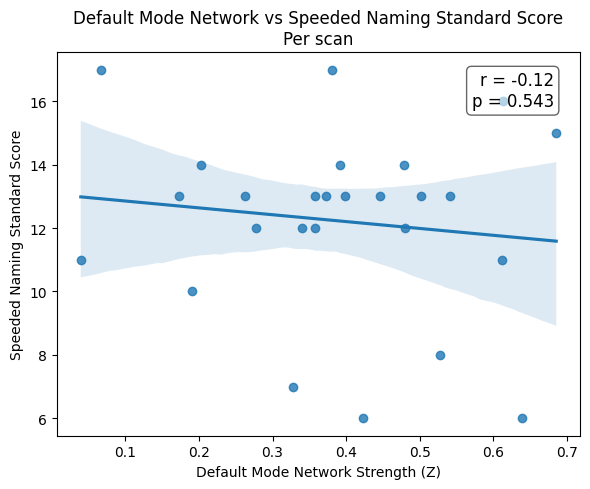

Per subject average → r = 0.367, p = 0.178
✅ Included 15 subjects for correlation.


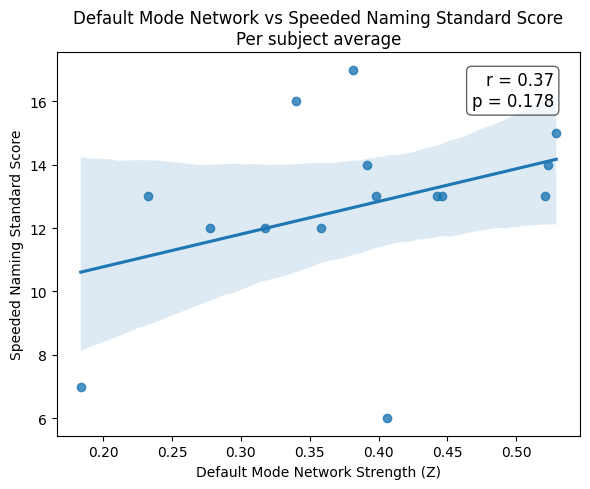

In [ ]:
# === Per scan compute network strength ===
# Per scan compute network strength
network_strength_list = []
subject_id_list = []
behavior_score_list = []

for idx, row in behavior_df_clean.iterrows():  # <== 改成 behavior_df_clean
    subject_id = str(row['PreschoolID'])
    z_mat_path = row['Z_matrix_path']

    try:
        z_mat = np.load(z_mat_path)
        mean_strength = compute_network_strength(z_mat, network_roi_idx)

        network_strength_list.append(mean_strength)
        subject_id_list.append(subject_id)
        behavior_score_list.append(row[behavior_score_col])
    except Exception as e:
        print(f'⚠️ Skipping subject {subject_id}: {e}')
        continue


# === Plot 1: Per scan ===
network_strength_list = np.array(network_strength_list)
behavior_score_list = np.array(behavior_score_list)

r, p = pearsonr(network_strength_list, behavior_score_list)
print(f'Per scan → r = {r:.3f}, p = {p:.3f}')
print(f'✅ Included {len(network_strength_list)} scans for correlation.')

plt.figure(figsize=(6, 5))
sns.regplot(x=network_strength_list, y=behavior_score_list)
plt.xlabel(f'{target_network} Network Strength (Z)')
plt.ylabel(behavior_score_col)
plt.title(f'{target_network} Network vs {behavior_score_col}\nPer scan')

plt.text(
    0.95, 0.95,
    f'r = {r:.2f}\np = {p:.3f}',
    transform=plt.gca().transAxes,
    ha='right',
    va='top',
    fontsize=12,
    bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white', alpha=0.6)
)

plt.tight_layout()
plt.savefig(f'your_file_path_{target_network}_strength_vs_{behavior_score_col}_per_scan.png', dpi=300)
plt.show()

# === Per subject average ===
df_strength = pd.DataFrame({
    'PreschoolID': subject_id_list,
    'NetworkStrength': network_strength_list,
    'BehaviorScore': behavior_score_list
})

df_strength_group = df_strength.groupby('PreschoolID').agg({
    'NetworkStrength': 'mean',
    'BehaviorScore': 'first'
}).reset_index()

network_strength_clean = df_strength_group['NetworkStrength'].values
behavior_score_clean = df_strength_group['BehaviorScore'].values

r, p = pearsonr(network_strength_clean, behavior_score_clean)
print(f'Per subject average → r = {r:.3f}, p = {p:.3f}')
print(f'✅ Included {len(network_strength_clean)} subjects for correlation.')

plt.figure(figsize=(6, 5))
sns.regplot(x=network_strength_clean, y=behavior_score_clean)
plt.xlabel(f'{target_network} Network Strength (Z)')
plt.ylabel(behavior_score_col)
plt.title(f'{target_network} Network vs {behavior_score_col}\nPer subject average')

plt.text(
    0.95, 0.95,
    f'r = {r:.2f}\np = {p:.3f}',
    transform=plt.gca().transAxes,
    ha='right',
    va='top',
    fontsize=12,
    bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white', alpha=0.6)
)

plt.tight_layout()
plt.show()